In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump


In [ ]:
# Load train and test datasets
X_train = pd.read_csv('/content/X_train.csv')
X_test = pd.read_csv('/content/X_test.csv')
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()
y_test = pd.read_csv('/content/Y_test.csv').values.ravel()

# Display the shapes of datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Training set shape: (5686, 9)
Test set shape: (1896, 9)
Training labels shape: (5686,)
Test labels shape: (1896,)


In [ ]:
# Define the pipeline with StandardScaler, ADASYN, and XGBoost Classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Standardize features
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # XGBoost Classifier
])

print("Pipeline defined with StandardScaler, ADASYN, and XGBoost Classifier.")


Pipeline defined with StandardScaler, ADASYN, and XGBoost Classifier.


In [ ]:
# Define the parameter grid for XGBoost
param_grid = {
    'xgb__n_estimators': [100, 200],            # Number of boosting rounds
    'xgb__learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'xgb__max_depth': [3, 4, 5],                 # Maximum tree depth
    'xgb__subsample': [0.8, 1.0],                # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8, 1.0],        # Subsample ratio of columns when constructing each tree
    'xgb__gamma': [0, 0.1, 0.2],                 # Minimum loss reduction required to make a further partition
    'xgb__scale_pos_weight': [1, 2]              # Controls the balance of positive and negative weights
}

# Scoring metrics for evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

print("Parameter grid and scoring metrics defined.")


Parameter grid and scoring metrics defined.


In [ ]:
# Setup StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # Choose the best model based on f1-score
    cv=cv,
    n_jobs=-1
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}


In [ ]:
# Predict on the test set using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.8929
Precision: 0.8992
Recall: 0.8929
F1 Score: 0.8941
Confusion Matrix:
[[1065  145]
 [  58  628]]


In [ ]:
# Generate and display the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      1210
           1       0.81      0.92      0.86       686

    accuracy                           0.89      1896
   macro avg       0.88      0.90      0.89      1896
weighted avg       0.90      0.89      0.89      1896



In [ ]:
# Save the best model to a file using joblib
dump(grid_search.best_estimator_, 'xgb_model_grid.joblib')
print("Model saved as 'xgb_model_grid.joblib'")


Model saved as 'xgb_model_grid.joblib'


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Load train and test datasets (modify paths as necessary)
X_train = pd.read_csv('/content/X_train.csv')  # Update the path as needed
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()  # Convert to 1D array

# Define the pipeline with ADASYN and XGBoost Classifier
pipeline = ImbPipeline([
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling
    ('xgb', xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))  # XGBoost without use_label_encoder
])

# Setup StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the F1 scores for each fold
f1_scores = []

# Perform stratified cross-validation
for train_index, test_index in cv.split(X_train, y_train):
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train[train_index], y_train[test_index]

    # Fit the model on the training fold
    pipeline.fit(X_cv_train, y_cv_train)

    # Predict on the test fold
    y_cv_pred = pipeline.predict(X_cv_test)

    # Calculate F1 score and append to the list
    f1 = f1_score(y_cv_test, y_cv_pred, average='weighted')
    f1_scores.append(f1)

# Calculate the average F1 score across all folds
average_f1_score = np.mean(f1_scores)

# Display the results
print(f"F1 Scores for each fold: {f1_scores}")
print(f"Average F1 Score: {average_f1_score:.4f}")


F1 Scores for each fold: [0.895723262220602, 0.8919266985265928, 0.911100993949294, 0.9035761803963112, 0.8930373206969405]
Average F1 Score: 0.8991


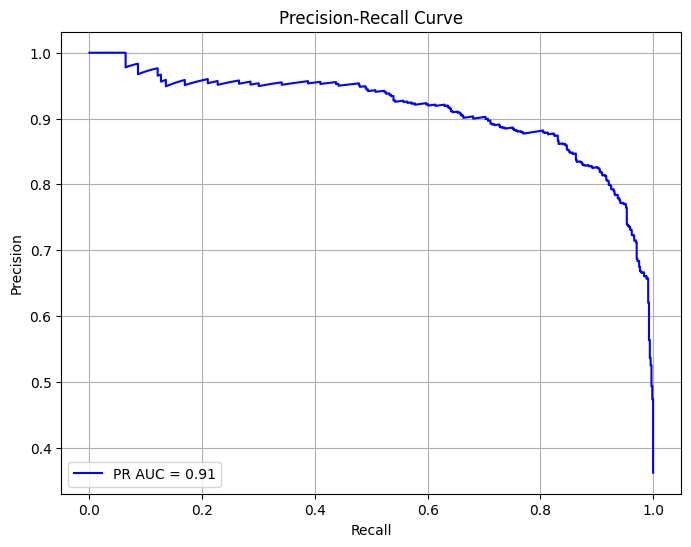

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Load train and test datasets (Update the file paths accordingly)
X_train = pd.read_csv('/content/X_train.csv')
X_test = pd.read_csv('/content/X_test.csv')
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()
y_test = pd.read_csv('/content/Y_test.csv').values.ravel()

# Define the pipeline with StandardScaler, ADASYN, and XGBoost Classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Standardize features
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # XGBoost Classifier
])

# Train the model
pipeline.fit(X_train, y_train)

# Get predicted probabilities for the test set
y_proba = pipeline.predict_proba(X_test)

# Plot Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_proba):
    # Calculate precision, recall, and thresholds
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])

    # Calculate the area under the curve (AUC)
    pr_auc = auc(recall, precision)

    # Plotting the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Call the function to plot the precision-recall curve
plot_precision_recall_curve(y_test, y_proba)


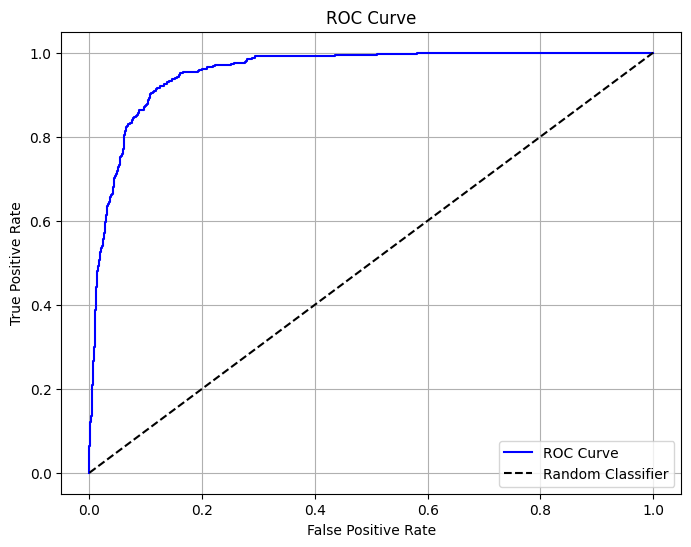

Threshold: 0.10
Precision: 0.7070, Recall: 0.9708, F1-Score: 0.8182
Confusion Matrix:
[[934 276]
 [ 20 666]]

Threshold: 0.20
Precision: 0.7423, Recall: 0.9534, F1-Score: 0.8347
Confusion Matrix:
[[983 227]
 [ 32 654]]

Threshold: 0.30
Precision: 0.7712, Recall: 0.9431, F1-Score: 0.8485
Confusion Matrix:
[[1018  192]
 [  39  647]]

Threshold: 0.40
Precision: 0.7923, Recall: 0.9286, F1-Score: 0.8550
Confusion Matrix:
[[1043  167]
 [  49  637]]

Threshold: 0.50
Precision: 0.8132, Recall: 0.9140, F1-Score: 0.8607
Confusion Matrix:
[[1066  144]
 [  59  627]]

Threshold: 0.60
Precision: 0.8253, Recall: 0.8950, F1-Score: 0.8587
Confusion Matrix:
[[1080  130]
 [  72  614]]

Threshold: 0.70
Precision: 0.8463, Recall: 0.8586, F1-Score: 0.8524
Confusion Matrix:
[[1103  107]
 [  97  589]]

Threshold: 0.80
Precision: 0.8771, Recall: 0.8222, F1-Score: 0.8488
Confusion Matrix:
[[1131   79]
 [ 122  564]]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Load train and test datasets (Update file paths as needed)
X_train = pd.read_csv('/content/X_train.csv')
X_test = pd.read_csv('/content/X_test.csv')
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()
y_test = pd.read_csv('/content/Y_test.csv').values.ravel()

# Define the pipeline with StandardScaler, ADASYN, and XGBoost Classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Standardize features
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # XGBoost Classifier
])

# Train the model
pipeline.fit(X_train, y_train)

# Get predicted probabilities for the test set
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Only the positive class probabilities

# Plot ROC Curve and capture different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='b')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Evaluate model at different thresholds
def evaluate_at_threshold(threshold, y_test, y_proba):
    # Apply threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate precision, recall, f1-score, and confusion matrix
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the results
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

# Loop over different threshold values from the ROC curve
for threshold in np.arange(0.1, 0.9, 0.1):
    evaluate_at_threshold(threshold, y_test, y_proba)


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump

# Load train and test datasets (Update file paths accordingly)
X_train = pd.read_csv('/content/X_train.csv')
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()
X_test = pd.read_csv('/content/X_test.csv')  # Load test dataset
y_test = pd.read_csv('/content/Y_test.csv').values.ravel()  # Load true labels for test dataset

# Define the pipeline with StandardScaler, ADASYN, and XGBoost Classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Standardize features
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling to balance classes
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # XGBoost Classifier
])

# Stratified k-fold cross-validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store the optimal thresholds for each fold
optimal_thresholds = []

# Perform stratified cross-validation to find the best threshold
for train_idx, val_idx in cv.split(X_train, y_train):
    # Split the data into training and validation for the current fold
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

    # Fit the pipeline on training data
    pipeline.fit(X_cv_train, y_cv_train)

    # Get the predicted probabilities for the validation set
    y_proba = pipeline.predict_proba(X_cv_val)[:, 1]  # Positive class probabilities

    # Get the ROC curve to evaluate different thresholds
    fpr, tpr, thresholds = roc_curve(y_cv_val, y_proba)

    # Initialize variables to store the best threshold and the highest F1-score
    best_threshold = 0.5
    best_f1 = 0.0

    # Iterate over thresholds and evaluate each one
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Convert probabilities to predictions

        # Calculate the F1-score at the current threshold
        f1 = f1_score(y_cv_val, y_pred)

        # If this F1-score is the best so far, store it
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Store the best threshold for this fold
    optimal_thresholds.append(best_threshold)
    print(f'Best threshold for this fold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}')

# Calculate the average optimal threshold across all folds
avg_optimal_threshold = np.mean(optimal_thresholds)
print(f"\nOptimal threshold across all folds: {avg_optimal_threshold:.4f}")

# Train the final model on the entire training set
pipeline.fit(X_train, y_train)

# Save the trained model using joblib
dump(pipeline, 'final_model.joblib')

# Get the predicted probabilities for the test set to evaluate the performance
y_proba_test = pipeline.predict_proba(X_test)[:, 1]

# Apply the optimal threshold to make final predictions on the test set
y_pred_test = (y_proba_test >= avg_optimal_threshold).astype(int)

# Evaluate the final model using precision, recall, and F1-score on the test set
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)

# Display final evaluation metrics for the test set
print(f"Final model performance on test data with optimal threshold {avg_optimal_threshold:.4f}:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Display confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:\n{conf_matrix}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Best threshold for this fold: 0.4947, Best F1-score: 0.8621
Best threshold for this fold: 0.3841, Best F1-score: 0.8678
Best threshold for this fold: 0.3313, Best F1-score: 0.8788
Best threshold for this fold: 0.3153, Best F1-score: 0.8728
Best threshold for this fold: 0.4805, Best F1-score: 0.8666

Optimal threshold across all folds: 0.4012
Final model performance on test data with optimal threshold 0.4012:
Precision: 0.7920, Recall: 0.9271, F1-Score: 0.8543, Accuracy: 0.8855

Confusion Matrix:
[[1043  167]
 [  50  636]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      1210
           1       0.79      0.93      0.85       686

    accuracy                           0.89      1896
   macro avg       0.87      0.89      0.88      1896
weighted avg       0.90      0.89      0.89      1896



In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump

# Load train and test datasets (Update file paths accordingly)
X_train = pd.read_csv('/content/X_train.csv')
y_train = pd.read_csv('/content/Y_train.csv').values.ravel()
X_test = pd.read_csv('/content/X_test.csv')  # Load test dataset
y_test = pd.read_csv('/content/Y_test.csv').values.ravel()  # Load true labels for test dataset

# Define the pipeline with StandardScaler, ADASYN, and XGBoost Classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Standardize features
    ('adasyn', ADASYN(random_state=42)),  # ADASYN oversampling to balance classes
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # XGBoost Classifier
])

# Hyperparameter tuning for XGBoost
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
}

# Stratified k-fold cross-validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implement GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model and parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# To store the optimal thresholds for each fold
optimal_thresholds = []

# Perform stratified cross-validation to find the best threshold
for train_idx, val_idx in cv.split(X_train, y_train):
    # Split the data into training and validation for the current fold
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

    # Fit the best pipeline on training data
    best_pipeline.fit(X_cv_train, y_cv_train)

    # Get the predicted probabilities for the validation set
    y_proba = best_pipeline.predict_proba(X_cv_val)[:, 1]  # Positive class probabilities

    # Get the ROC curve to evaluate different thresholds
    fpr, tpr, thresholds = roc_curve(y_cv_val, y_proba)

    # Initialize variables to store the best threshold and the highest F1-score
    best_threshold = 0.5
    best_f1 = 0.0

    # Iterate over thresholds and evaluate each one
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Convert probabilities to predictions

        # Calculate the F1-score at the current threshold
        f1 = f1_score(y_cv_val, y_pred)

        # If this F1-score is the best so far, store it
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Store the best threshold for this fold
    optimal_thresholds.append(best_threshold)
    print(f'Best threshold for this fold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}')

# Calculate the average optimal threshold across all folds
avg_optimal_threshold = np.mean(optimal_thresholds)
print(f"\nOptimal threshold across all folds: {avg_optimal_threshold:.4f}")

# Train the final model on the entire training set using the best pipeline
best_pipeline.fit(X_train, y_train)

# Save the trained model using joblib
dump(best_pipeline, 'final_model.joblib')

# Get the predicted probabilities for the test set to evaluate the performance
y_proba_test = best_pipeline.predict_proba(X_test)[:, 1]

# Apply the optimal threshold to make final predictions on the test set
y_pred_test = (y_proba_test >= avg_optimal_threshold).astype(int)

# Evaluate the final model using precision, recall, and F1-score on the test set
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)

# Display final evaluation metrics for the test set
print(f"Final model performance on test data with optimal threshold {avg_optimal_threshold:.4f}:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Display confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:\n{conf_matrix}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Best parameters found: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best threshold for this fold: 0.4830, Best F1-score: 0.8786
Best threshold for this fold: 0.2599, Best F1-score: 0.8670
Best threshold for this fold: 0.3547, Best F1-score: 0.8907
Best threshold for this fold: 0.3409, Best F1-score: 0.8728
Best threshold for this fold: 0.6483, Best F1-score: 0.8771

Optimal threshold across all folds: 0.4174
Final model performance on test data with optimal threshold 0.4174:
Precision: 0.8033, Recall: 0.9227, F1-Score: 0.8589, Accuracy: 0.8903

Confusion Matrix:
[[1055  155]
 [  53  633]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1210
           1       0.80      0.92      0.86       686

    accuracy                           0.89      1896
   macro avg       0.88      0.90      0.88      1896
weighted avg       0.90      0.89      0.89      1896

